## Autoencoder

**Autoencoder** is a neural network designed to learn an identity function in an unsupervised way  to reconstruct the original input while compressing the data in the process so as to discover a more efficient and compressed representation. The idea was originated in [the 1980s](https://en.wikipedia.org/wiki/Autoencoder), and later promoted by the seminal paper by [Hinton & Salakhutdinov, 2006](https://pdfs.semanticscholar.org/c50d/ca78e97e335d362d6b991ae0e1448914e9a3.pdf).

It consists of two networks:
- *Encoder* network: It translates the original high-dimension input into the latent low-dimensional code. The input size is larger than the output size.
- *Decoder* network: The decoder network recovers the data from the code, likely with larger and larger output layers.


<img src="images/autoencoder-architecture.png" width="80%">


The encoder network essentially accomplishes the [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction), just like how we would use Principal Component Analysis (PCA) or Matrix Factorization (MF) for. In addition, the autoencoder is explicitly optimized for the data reconstruction from the code. A good intermediate representation not only can capture latent variables, but also benefits a full [decompression](https://ai.googleblog.com/2016/09/image-compression-with-neural-networks.html) process.

The model contains an encoder function $g(.)$ parameterized by $\phi$ and a decoder function $f(.)$ parameterized by $\theta$. The low-dimensional code learned for input $\mathbf{x}$ in the bottleneck layer is $\mathbf{z} = $ and the reconstructed input is $\mathbf{x}' = f_\theta(g_\phi(\mathbf{x}))$.

The parameters $(\theta, \phi)$ are learned together to output a reconstructed data sample same as the original input, $\mathbf{x} \approx f_\theta(g_\phi(\mathbf{x}))$, or in other words, to learn an identity function. There are various metrics to quantify the difference between two vectors, such as cross entropy when the activation function is sigmoid, or as simple as MSE loss:

$$
L_\text{AE}(\theta, \phi) = \frac{1}{n}\sum_{i=1}^n (\mathbf{x}^{(i)} - f_\theta(g_\phi(\mathbf{x}^{(i)})))^2
$$

In [18]:
import torch
import torch.nn as nn
import torch.optim as optimization
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as data
import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary


def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor


def tensor_round(tensor):
    return torch.round(tensor)

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:min_max_normalization(tensor, 0, 1)),
    transforms.Lambda(lambda tensor:tensor_round(tensor))
])

# 28x28
train_dataset = data.MNIST(root='.data', train=True,
                           transform=img_transform, download=True)

num_epochs = 200
batch_size = 128
learning_rate = 1e-3

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

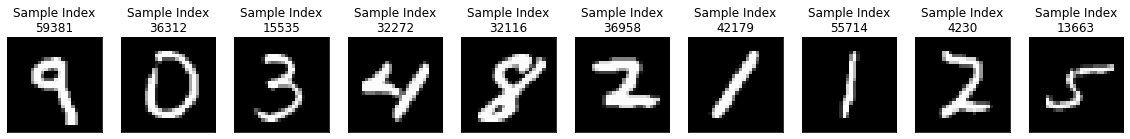

In [19]:
def plot_mnist_sample(tensor, sample_idx=None, size=10):
    """Plot MNIST samples from tensor.
    """
    # sample from data if sample indices are not provided
    if sample_idx is None:
        # get sample indices
        sample_idx = np.random.uniform(size=size) * tensor.shape[0]
        sample_idx = sample_idx.astype(int)
    # plot data
    nrows = int(np.ceil(len(sample_idx)/10))
    fig, axes = plt.subplots(nrows=nrows, ncols=10, figsize=(20,2))
    for i, s in enumerate(sample_idx):
        ax = axes.item(i)
        ax.imshow(tensor[s].numpy())
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Sample Index\n{}".format(s))
        
plot_mnist_sample(train_dataset.data)

In [27]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, stride=1), nn.ReLU(True),
                                    nn.Conv2d(32, 32, kernel_size=5, stride=1), nn.ReLU(True),
                                    nn.Conv2d(32, 32, kernel_size=4, stride=2), nn.ReLU(True),
                                    nn.Conv2d(32, 32, kernel_size=3, stride=2), nn.ReLU(True),
                                    nn.Conv2d(32, 8, kernel_size=4, stride=1))
        
        self.decoder = nn.Sequential(nn.ConvTranspose2d(8, 32, kernel_size=4, stride=1), nn.ReLU(True),
                                    nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2), nn.ReLU(True),
                                    nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2), nn.ReLU(True),
                                    nn.ConvTranspose2d(32, 32, kernel_size=5, stride=1), nn.ReLU(True),
                                    nn.ConvTranspose2d(32, 1, kernel_size=5, stride=1))
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = AutoEncoder()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

## Denoising Autoencoder

Since the autoencoder learns the identity function, we are facing the risk of “overfitting” when there are more network parameters than the number of data points. 

To avoid overfitting and improve the robustness, **Denoising Autoencoder** (Vincent et al. 2008) proposed a modification to the basic autoencoder. The input is partially corrupted by adding noises to or masking some values of the input vector in a stochastic manner, $\tilde{\mathbf{x}} \sim \mathcal{M}_\mathcal{D}(\tilde{\mathbf{x}} \vert \mathbf{x})$. Then the model is trained to recover the original input (**Note: Not the corrupt one!**).


$$
\begin{aligned}
\tilde{\mathbf{x}}^{(i)} &\sim \mathcal{M}_\mathcal{D}(\tilde{\mathbf{x}}^{(i)} \vert \mathbf{x}^{(i)})\\
L_\text{DAE}(\theta, \phi) &= \frac{1}{n} \sum_{i=1}^n (\mathbf{x}^{(i)} - f_\theta(g_\phi(\tilde{\mathbf{x}}^{(i)})))^2
\end{aligned}
$$


where $\mathcal{M}_\mathcal{D}$ defines the mapping from the true data samples to the noisy or corrupted ones.

<img src="images/denoising-autoencoder-architecture.png" width="80%">


This design is motivated by the fact that humans can easily recognize an object or a scene even the view is partially occluded or corrupted. To “repair” the partially destroyed input, the denoising autoencoder has to discover and capture relationship between dimensions of input in order to infer missing pieces. 

For high dimensional input with high redundancy, like images, the model is likely to depend on evidence gathered from a combination of many input dimensions to recover the denoised version (sounds like the [attention]({{ site.baseurl }}{% post_url 2018-06-24-attention-attention %}) mechanism, right?) rather than to overfit one dimension. This builds up a good foundation for learning *robust* latent representation.

The noise is controlled by a stochastic mapping $$\mathcal{M}_\mathcal{D}(\tilde{\mathbf{x}} \vert \mathbf{x})$$, and it is not specific to a particular type of corruption process (i.e. masking noise, Gaussian noise, salt-and-pepper noise, etc.). Naturally the corruption process can be equipped with prior knowledge

In the experiment of the original DAE paper, the noise is applied in this way: a fixed proportion of input dimensions are selected at random and their values are forced to 0. Sounds a lot like dropout, right? Well, the denoising autoencoder was proposed in 2008, 4 years before the dropout paper ([Hinton, et al. 2012](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)) ;)

**Stacked Denoising Autoencoder**: In the old days when it was still hard to train deep neural networks, stacking denoising autoencoders was a way to build deep models ([Vincent et al., 2010](http://www.jmlr.org/papers/volume11/vincent10a/vincent10a.pdf)). The denoising autoencoders are trained layer by layer. Once one layer has been trained, it is fed with clean, uncorrupted inputs to learn the encoding in the next layer.

<img src="images/stacking-dae.png" width="80%">

Image source: [Vincent et al., 2010](http://www.jmlr.org/papers/volume11/vincent10a/vincent10a.pdf))*

## Sparse Autoencoder

**Sparse Autoencoder** applies a "sparse" constraint on the hidden unit activation to avoid overfitting and improve robustness. It forces the model to only have a small number of hidden units being activated at the same time, or in other words, one hidden neuron should be inactivate most of time.

Recall that common [activation functions](http://cs231n.github.io/neural-networks-1/#actfun) include sigmoid, tanh, relu, leaky relu, etc. A neuron is activated when the value is close to 1 and inactivate with a value close to 0.

Let’s say there are $s_l$ neurons in the $l$-th hidden layer and the activation function for the $j$-th neuron in this layer is labelled as $a^{(l)}_j(.)$, $j=1, \dots, s_l$. The fraction of activation of this neuron $\hat{\rho}_j$ is expected to be a small number $\rho$, known as *sparsity parameter*; a common config is $\rho = 0.05$.


$$
\hat{\rho}_j^{(l)} = \frac{1}{n} \sum_{i=1}^n [a_j^{(l)}(\mathbf{x}^{(i)})] \approx \rho
$$

This constraint is achieved by adding a penalty term into the loss function. The KL-divergence $D_\text{KL}$ measures the difference between two Bernoulli distributions, one with mean $$\rho$$ and the other with mean $\hat{\rho}_j^{(l)}$. The hyperparameter $\beta$ controls how strong the penalty we want to apply on the sparsity loss.


$$
\begin{aligned}
L_\text{SAE}(\theta) 
&= L(\theta) + \beta \sum_{l=1}^L \sum_{j=1}^{s_l} D_\text{KL}(\rho \| \hat{\rho}_j^{(l)}) \\
&= L(\theta) + \beta \sum_{l=1}^L \sum_{j=1}^{s_l} \rho\log\frac{\rho}{\hat{\rho}_j^{(l)}} + (1-\rho)\log\frac{1-\rho}{1-\hat{\rho}_j^{(l)}}
\end{aligned}
$$


![KL divergence]({{ '/assets/images/kl-metric-sparse-autoencoder.png' | relative_url }})
{: style="width: 80%;" class="center"}
*Fig. 4. The KL divergence between a Bernoulli distribution with mean $$\rho=0.25$$ and a Bernoulli distribution with mean $$0 \leq \hat{\rho} \leq 1$$.*

**$k$-Sparse Autoencoder**

In $k$-Sparse Autoencoder ([Makhzani and Frey, 2013](https://arxiv.org/abs/1312.5663)), the sparsity is enforced by only keeping the top k highest activations in the bottleneck layer with linear activation function. 
First we run feedforward through the encoder network to get the compressed code: $$\mathbf{z} = g(\mathbf{x})$$.
Sort the values  in the code vector $$\mathbf{z}$$. Only the k largest values are kept while other neurons are set to 0. This can be done in a ReLU layer with an adjustable threshold too. Now we have a sparsified code: $$\mathbf{z}’ = \text{Sparsify}(\mathbf{z})$$.
Compute the output and the loss from the sparsified code, $$L = \|\mathbf{x} - f(\mathbf{z}') \|_2^2$$.
And, the back-propagation only goes through the top k activated hidden units!


![k-sparse autoencoder]({{ '/assets/images/k-sparse-autoencoder.png' | relative_url }})
{: style="width: 100%;" class="center"}
*Fig. 5. Filters of the k-sparse autoencoder for different sparsity levels k, learnt from MNIST with 1000 hidden units.. (Image source: [Makhzani and Frey, 2013](https://arxiv.org/abs/1312.5663))*

## Contractive Autoencoder

Similar to sparse autoencoder, **Contractive Autoencoder** ([Rifai, et al, 2011](http://www.icml-2011.org/papers/455_icmlpaper.pdf)) encourages the learned representation to stay in a contractive space for better robustness. 

It adds a term in the loss function to penalize the representation being too sensitive to the input,  and thus improve the robustness to small perturbations around the training data points. The sensitivity is measured by the Frobenius norm of the Jacobian matrix of the encoder activations with respect to the input:


$$
\|J_f(\mathbf{x})\|_F^2 = \sum_{ij} \Big( \frac{\partial h_j(\mathbf{x})}{\partial x_i} \Big)^2
$$

where $$h_j$$ is one unit output in the compressed code $$\mathbf{z} = f(x)$$. 

This penalty term is the sum of squares of all partial derivatives of the learned encoding with respect to input dimensions. The authors claimed that empirically this penalty was found to  carve a representation that corresponds to a lower-dimensional non-linear manifold, while staying more invariant to majority directions orthogonal to the manifold.


## Variational Auto Encoders (VAE)

In a VAE, there is a strong assumption for the distribution that is learned in the hidden representation. The hidden representation is constrained to be a multivariate guassian. The motivation behind this is that we assume the hidden representation learns high level features and these features follow a very simple form of distribiution. Thus, we assume that each feature is a guassian distribiution and their combination which creates the hidden representation is a multivariate guassian.From a probabilistic graphical models prespective, an auto encoder can be seen as a directed graphical model where the hidden units are latent variables ($z$) and the following rule applies:

$$p_{\theta}(x,\ z) = p_{\theta}(z)\ p_{\theta}(x|z),$$


where $ \theta$  indicates that $p$  is parametrized by $ \theta$  . And according to the Bayes rule, the likelihood of the data ( $p_{ \theta}(x)$  ) can be derived using the following:

$$p_{ \theta}(x) =  \frac{p_{ \theta}(x| \ z) \ p_{ \theta}(z)}{p_{ \theta}(z, \ x)},$$ 
 
$p_{ \theta}(x|z)$ is the distribiution that generates the data ( $x$  ) and is tractable using the dataset. In a VAE it is assumed the prior distribiution ( $p_{ \theta}(z)$  ) is a multivariate normal distribiution (centered at zero with co-varience of $I$):

$$p_{ \theta}(z) =  \prod_{k=1} ^ N  \mathcal{N}(z_{k} \ | \ 0,1)$$  

The posterior distribiution ( $p_{ \theta}(z|x)$  ) is an intractable distribiution (never observed), but the encoder learns $q_{ \varphi}(z|x)$  as its estimator. As mentioned above, we assume $q_{ \varphi}(z|x)$  is a normal distribiution which is parameterized by ${ \varphi}$  :

$$q_{ \varphi}(z|x) =  \prod_{k=1} ^ N  \mathcal{N}(z_{k} \ | \  \mu_{k}(x), \  \sigma_{k}^2(x)).$$  

Now the likelihood is parameterized by $ \theta$  and $ \varphi$  . The goal is to find a $ \theta^{*}$  and a $ \varphi^{*}$  such that $log \ p_{ \theta,  \varphi}(x)$  is maximized. Or equivallently, we minimize the negative log-likelihood (nill):

In this setting, the following is a lower-bound on the log-likelihood of $x$  . 

$$ \mathcal{L}(x) = - D_{kl} \ (q_{ \varphi}(z|x) \ || \ p_{ \theta}(z)) + E_{q_{ \varphi} \ (z|x)}[ \ log p_{ \theta}(x \ | \ z)],$$  

The second term is a reconstruction error which is approximated by sampling from $q_{ \varphi}(z|x)$  (the encoder) and then computing $p_{ \theta}(x \ | \ z)$  (the decoder). The first term, $D_{kl}$  is the Kullback–Leibler divergence which measures the differnce between two probability distribiutions. The KL term encourges the model to learn a $q_{ \varphi}(z|x)$  that is of the form of $p_{ \theta}(z)$  which is a normal distribiution and acts as a regularizer. Considering that $p_{ \theta}(z)$  and $q_{ \varphi}(z|x)$  are normal distribiutions, the KL term can be simplified to the following form:

$$ D_{kl}=  \frac{1}{2} \  \sum_{k = 1}^{N} \ 1 \ + \ log( \sigma_{k}^2 (x))-  \mu_{k}^{2} (x) -  \sigma_{k}^2 (x)$$

<img src="images/vae.png" width="40%">


Variational Auto Encoder: the hidden units parameterize the multivariate normal distribiution $q_{ \varphi}(z|x)$ by finding a set of $( \  \mu, \  \sigma^2)$ . $  \mathcal{N}$ is a normal distribiution from which we sample and is used in the reparametrization trick.

### In short  
A variational autoencoder has a very similar structure to an autoencoder except for several changes: Strong assumption that the hidden representation follows a guassian distribiution. The loss function has a new regularizer term (KL term) which forces the hidden representation to be close to a normal distribiution. The model can be used for generation. Since the KL term makes sure that $q_{ \varphi}(z|x)$ and $p_{ \theta}(z)$ are close, one can sample from $q_{ \varphi}(z|x)$ to generate new datapoints which will look very much like training samples. 


### The Reparametrization 
Trick  The problem that might come to ones mind is that how the gradient flows through a VAE where it involves sampling from $q_{ \varphi}(z|x)$  which is a non-deterministic procedure. To tackle this problem, the reparametrization trick is used. In order to have a sample from the distribiution $  \mathcal{N}( \  \mu, \  \sigma^2)$  , one can first sample from a normal distribiution $  \mathcal{N}( \ 0, \ 1)$  and then calculate: 

$$  \mathcal{N}( \  \mu, \  \sigma^2) =  \mathcal{N}( \ 0, \ 1) *  \sigma^2 +  \mu$$ 

<img src="images/reparam.png" width="30%">


The reparametrization Trick: sampling from $  \mathcal{N}( \  \mu, \  \sigma^2)$ is non-deteministic and thus the gradient can not be passed through it. If one samples from the noraml distribiution $  \mathcal{N}( \ 0, \ 1)$ and just scale and move it using the parameters $ \sigma^2, \  \mu$ , the backward pass will be deterministic. 

PyTorch implementation of a VAE. The code also generates new samples. It also does a generation with interpolation which means that it starts from one sample and moves towards another sample in the latent space and generates new samples by interpolating between the mean and the variance of the first and second sample. Fig7. shows the generated samples with interpolation. Fig7. From left to right: generated samples with interpolation at 1st, 40th, 80th, 150th and 200th epochs"

### VAE cost function in detail

In VAE, we want to model the data distribution $p(x)$ with an encoder $ q_ϕ(z \vert x)$ , a decoder $p_θ(x  \vert z) $ and a latent variable model $p(z)$ through the VAE objective function:

$$
\log p(x) \approx \mathbb{E}_q [   \log p_θ (x \vert z)] - D_{KL} [q_ϕ (z \vert x) \Vert p(z)]   \\
$$

To draw this conclusion, we start with the KL divergence which measures the difference of 2 distributions. By definition, KL divergence is defined as: 

$$
\begin{align}
D_{KL}\left(q \Vert p\right) & = \sum_{x} q(x) \log (\frac{q(x)}{p(x)}) \\ 
& = \mathbb{E}_q[log (q(x))−log (p(x))] \\
\end{align}
$$


Apply it with:

$$
\begin{align}
D_{KL}[q(z \vert x) \Vert p(z \vert x)] &= \mathbb{E}[\log q(z \vert x) - \log p(z \vert x)] \\
\end{align}
$$


Let $ q_\lambda (z \vert x) $ be the distribution of $ z $ predicted by our encoder deep network. We want it to match the true distribution $ p(z \vert x) $. We want the distribution approximated by the deep network has little divergence from the true distribution. i.e. we want to optimize $\lambda $ with the smallest KL divergence.

$$
D_{KL} [ q_λ (z \vert x) \Vert p(z \vert x) ] = \mathbb{E}_q [ \log q_λ (z \vert x)  -   \log p (z \vert x) ]
$$

Apply:

$$
p(z \vert x) = \frac{p(x \vert z) p(z)}{p(x)}
$$

$$
\begin{align}
D_{KL} [ q_\lambda (z \vert x) \Vert p(z \vert x)  ] & = \mathbb{E}_q [ \log q_λ (z \vert x) - \log \frac{ p (x \vert z) p(z)}{p(x)}  ] \\
& = \mathbb{E}_q [ \log q_λ (z \vert x)  - \log p (x \vert z) - \log p(z)  + \log p(x)]   \\
& = \mathbb{E}_q [ \log q_λ (z \vert x)  - \log p (x \vert z) - \log p(z) ] + \log p(x) \\
 D_{KL} [ q_\lambda (z \vert x) \Vert p(z \vert x)  ]  - \log p(x) & = \mathbb{E}_q [ \log q_λ (z \vert x)  - \log p (x \vert z) - \log p(z) ] \\
 \log p(x) - D_{KL} [ q_\lambda (z \vert x) \Vert p(z \vert x)  ]  & = \mathbb{E}_q [   \log p (x \vert z) - ( \log q_λ (z \vert x) - \log p(z)) ] \\
&=  \mathbb{E}_q [   \log p (x \vert z)] - \mathbb{E}_q [ \log q_λ (z \vert x) - \log p(z)) ] \\
&=  \mathbb{E}_q [   \log p (x \vert z)] - D_{KL} [q_λ (z \vert x) \Vert p(z)] \\
\end{align}
$$

Define the term ELBO (Evidence lower bound) as:

$$
\begin{align}
ELBO(λ) & =  \mathbb{E}_q [   \log p (x \vert z)] - D_{KL} [q_λ (z \vert x) \Vert p(z)] \\
\log p(x) - D_{KL} [ q_\lambda (z \vert x) \Vert p(z \vert x)  ] & = ELBO(λ)  \\
\end{align}
$$

We call ELBO the evidence lower bound because:

$$
\begin{align}
\log p(x) - D_{KL} [ q_\lambda (z \vert x) \Vert p(z \vert x)  ] & = ELBO(λ) \\
\log p(x) & \geqslant ELBO(λ) \quad \text{since KL is always positive} \\
\end{align}
$$

Here, we define our VAE objective function

> $$ \log p(x) - D_{KL} [ q_\lambda (z \vert x) \Vert p(z \vert x)  ] = \mathbb{E}_q [   \log p (x \vert z)] - D_{KL} [q_λ (z \vert x) \Vert p(z)]  $$


Instead of the distribution $p(x)$, we can model the data $x$ with $ \log p(x) $. With the error term, $D_{KL} [ q_\lambda (z \vert x) \Vert p(z \vert x)  ]$, we can establish a lower bound $ELBO$ for $ \log p(x) $ which in practice is good enough in modeling the data distribution. In the VAE objective function, maximize our model probability $ \log p(x) $ is the same as maximize $ \log p (x \vert z)]$ while minimize the divergence of $D_{KL} [q_λ (z \vert x) \Vert p(z)] $. 

Maximizing $\log p (x \vert z)$ can be done by building a decoder network and maximize its likelihood. So with an encoder $ q_ϕ(z \vert x)$ , a decoder $p_θ(x  \vert z) $, our objective become optimizing:

$$
ELBO(\theta, \phi) = E_{q_\theta(z \vert x) }  [  \log (p_{\theta}(x_{i}|z))  ] - D_{KL} [ q_\phi (z \vert x) \Vert p(z) ]
$$

We can apply a constrain to $ p(z) $ such that we can evaluate $D_{KL} [ q_\phi (z \vert x) \Vert p(z) ]$ easily. In AVE, we use  $ p(z) = \mathcal{N} (0, 1) $. For optimal solution, we want $ q_\phi (z \vert x) $ to be as close as $\mathcal{N} (0, 1) $.

In VAE, we model $ q_\phi (z \vert x) $ as $ \mathcal{N} (\mu, \Sigma)$

$$
\begin{align}
D_{KL} [ q_\phi (z \vert x) \Vert p(z) ] &= D_{KL}[N(\mu, \Sigma) \Vert N(0, 1)] \\
& = \frac{1}{2} \, ( \textrm{tr}(\Sigma) + \mu^T\mu - k - \log \, \det(\Sigma) ) \\
& = \frac{1}{2} \, ( \sum_k \Sigma + \sum_k \mu^2 - \sum_k 1 - \log \, \prod_k \Sigma ) \\
& = \frac{1}{2} \, ( \sum_k \Sigma(X) + \sum_k \mu^2(X) - \sum_k 1 - \sum_k \log \Sigma(X) ) \\
& = \frac{1}{2} \, \sum_k ( \Sigma + \mu^2 - 1 - \log \Sigma )
\end{align}
$$

### KL-divergence of 2 Gaussian distributions

Here is an exercise in computing the KL divergence of 2 simple gaussian distributions:

$$
p(x) = N(\mu_1, \sigma_1) \\
q(x) = N(\mu_2, \sigma_2)
$$

$$
\begin{align}
KL(p, q) &= \int \left[\log( p(x)) - log( q(x)) \right] p(x) dx \\
& = E_1 \left[ -\frac{1}{2} \log(2\pi) - \log(\sigma_1) - \frac{1}{2} \left(\frac{x-\mu_1}{\sigma_1}\right)^2 + \frac{1}{2}\log(2\pi) + \log(\sigma_2) + \frac{1}{2} \left(\frac{x-\mu_2}{\sigma_2}\right)^2  \right] \\
&=E_{1} \left\{\log\left(\frac{\sigma_2}{\sigma_1}\right) + \frac{1}{2} \left[ \left(\frac{x-\mu_2}{\sigma_2}\right)^2 - \left(\frac{x-\mu_1}{\sigma_1}\right)^2 \right]\right\} \\
& =\log\left(\frac{\sigma_2}{\sigma_1}\right) + \frac{1}{2\sigma_2^2} E_1 \left\{(X-\mu_2)^2\right\} - \frac{1}{2\sigma_1^2} E_1 \left\{(X-\mu_1)^2\right\} \\
& =\log\left(\frac{\sigma_2}{\sigma_1}\right) + \frac{1}{2\sigma_2^2} E_1 \left\{(X-\mu_2)^2\right\} - \frac{1}{2} \quad \text{ because } E_1 \left\{(X-\mu_1)^2\right\} = \sigma_1^2\\
Note: & (X - \mu_2)^2 = (X-\mu_1+\mu_1-\mu_2)^2 = (X-\mu_1)^2 + 2(X-\mu_1)(\mu_1-\mu_2) + (\mu_1-\mu_2)^2 \\
KL(p, q) & = \log\left(\frac{\sigma_2}{\sigma_1}\right) + \frac{1}{2\sigma_2^2}
\left[E_1\left\{(X-\mu_1)^2\right\} + 2(\mu_1-\mu_2)E_1\left\{X-\mu_1\right\} + (\mu_1-\mu_2)^2\right] - \frac{1}{2} \\
& = \log\left(\frac{\sigma_2}{\sigma_1}\right) + \frac{\sigma_1^2 + (\mu_1-\mu_2)^2}{2\sigma_2^2} - \frac{1}{2} \\
\end{align}
$$